The United States is experiencing a significant problem in air traffic control staffing. The air traffic control system is complicated with controllers following the flight over every step of the route starting with pushing away from the gate to pulling into the gate at the destination airport. This system relys on about 14,000 controllers managing about 45,000 flights in a given day. In the 1980s, President Reagan fired about 11,000 air traffic controllers and replaced them with new employees, due to a union strike. Now, this "class" of controllers is retiring and the new "class" is unable to fill all of those spots. Another reason for the shortage is the training process itself. It takes a high level of skill to be proficient in that career and therefore a significant training process. During COVID, training was stopped and it takes a long time to get caught back up. The system also makes it difficult for employees to move around to different facilities as the training proccess (a sort of apprenticeship model) means switching facilities involves a time period for training to become a full controller at the new facility. (Information from Freakonomics Radio - Is the Air Traffic Control System Broken? Source 4)

Many news outlets are indicating that this air traffic control shortage is leading to delays, especially during the government shutdown when the conrollers were not getting paychecks. An example is from U.S. News - Air Traffic Controller Shortages Lead to Broader US Flight Delays as Shutdown Nears One-Month Mark (source 5). How many flights are actually delayed due to air traffic control? Are these news articles making a bigger deal out of this shortage? Are delays getting worse over the course of this year? Are there any specific facilities that are experiencing more issues with delays than others?

The first step to answering these questions is to understand how flights are classified as delayed. Flights that depart or arrive more than 15 minutes past their scheduled time are considered delayed and fall into 1 of 5 categories. Carrier delays are delays caused by the airline, for example the crew was late, the plane had a malfunction, etc. Weather delays are caused by hazardous weather at any point enroute. National Airspace System (NAS) delays are due to problems with the NAS, a network that manages the airspaces and includes air traffic control staffing and equiptment, airports themselves, rules and regulations, charts, etc (source 6). Security delays are due to security wait times of over 29 min or due to another security issue. Finally, Late Aircraft delays happen when the aircraft arrives late due to a late arrival at the previous airport (delay propogation). (Source 7).

The U.S. Buearu of Transportation has a publically available dataset of information regarding flights from 1987 to July of 2025. This dataset is a record of every flight for every day since 1987 (source 1). This dataset will be wrangled and analyzed for a better understanding in flight delays. 



In [ ]:
!pip install airportsdata
!pip install geopandas
!pip install pygris

In [243]:
import pandas as pd
from datetime import datetime
import pygris
from pygris import states
from pygris.utils import shift_geometry
import networkx as nx
import airportsdata
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.stats import spearmanr

Once the necessary packages are downloaded and imported, the data is read in. The first dataset being examined is flight data for March of 2025. This month was chosen at random out of the availible data for 2025. The steps taken to wrangle the data are as follows
1. Read in and examine the dataset
2. Select the columns of interest
3. Filter for the appropriate data (domestic, delayed flights)
Following wrangling, analysis of the data will take place using the networkx and pygris packages. 
1. Create a networkx object from the data
2. Set up graphing options
3. Initialize the U.S. map underlay
4. Map the network to the U.S. map
5. Determine degree and betweenness centralities, in addition to other statistics

In [63]:
# 1. Read in the March dataset downloaded from the bureau of transportation
march = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_3/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_3.csv')
march.head() #examine the dataset

C:\Users\abiga\AppData\Local\Temp\ipykernel_4044\1279242050.py:2: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  march = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_3/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_3.csv')


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2025        1      3           1          6  2025-03-01                AA   
1  2025        1      3           2          7  2025-03-02                AA   
2  2025        1      3           3          1  2025-03-03                AA   
3  2025        1      3           4          2  2025-03-04                AA   
4  2025        1      3           5          3  2025-03-05                AA   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19805                          AA      N112AN  ...   
1                     19805                          AA      N110AN  ...   
2                     19805                          AA      N112AN  ...   
3                     19805                          AA      N101NN  ...   
4                     19805                          AA      N102NN  ...   

   Div4TailNum  Div5Airport  Div5AirportID  Div5AirportSeqID Div5WheelsOn  \
0          NaN          NaN            NaN               NaN          NaN   
1          NaN          NaN            NaN               NaN          NaN   
2          NaN          NaN            NaN               NaN          NaN   
3          NaN          NaN            NaN               NaN          NaN   
4          NaN          NaN            NaN               NaN          NaN   

  Div5TotalGTime Div5LongestGTime  Div5WheelsOff Div5TailNum  Unnamed: 109  
0            NaN              NaN            NaN         NaN           NaN  
1            NaN              NaN            NaN         NaN           NaN  
2            NaN              NaN            NaN         NaN           NaN  
3            NaN              NaN            NaN         NaN           NaN  
4            NaN              NaN            NaN         NaN           NaN  

[5 rows x 110 columns]

In [81]:
# 2. Selecting just the columns of interest. 
#Columns that identify the airline, the flight, the date, the destination, the origin and the type of delay
#originally I used a slice method to identify the names of the columns of interest
airDataM = march[['FlightDate', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
              'Origin', 'OriginCityName', 'OriginCityMarketID', 'DepDelay',
              'Dest', 'DestCityName', 'DestCityMarketID', 'ArrDelay',
              'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].copy()
#Rename the longer columns for easier calling
airDataM.rename(columns = {'DOT_ID_Reporting_Airline':'DOT_ID', 'IATA_CODE_Reporting_Airline':'IATA_Code'}, inplace=True)

airDataM.info() # Taking an initial glance 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600872 entries, 0 to 600871
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FlightDate          600872 non-null  object 
 1   DOT_ID              600872 non-null  int64  
 2   IATA_Code           600872 non-null  object 
 3   Tail_Number         600104 non-null  object 
 4   Origin              600872 non-null  object 
 5   OriginCityName      600872 non-null  object 
 6   OriginCityMarketID  600872 non-null  int64  
 7   DepDelay            594263 non-null  float64
 8   Dest                600872 non-null  object 
 9   DestCityName        600872 non-null  object 
 10  DestCityMarketID    600872 non-null  int64  
 11  ArrDelay            592301 non-null  float64
 12  CarrierDelay        116034 non-null  float64
 13  WeatherDelay        116034 non-null  float64
 14  NASDelay            116034 non-null  float64
 15  SecurityDelay       116034 non-nul

The airportsdata package is a nested dictionary object that contains information on airports and is keyed by the airport's code. In this case, the key is the airport IATA code which is also included in the dataframe. Using the airportsdata package, the data can be filtered to only domestic flights. 

In [7]:
#This is a nested dictionary object that contains information about airports
iata_airports = airportsdata.load('IATA') # key is the IATA location code
print(iata_airports['STT']) #looking at the structure of the nested dictionary

{'icao': 'TIST', 'iata': 'STT', 'name': 'Cyril E King Airport', 'city': 'Charlotte Amalie', 'subd': 'Virgin Islands', 'country': 'US', 'elevation': 23.6, 'lat': 18.33731, 'lon': -64.97333, 'tz': 'America/St_Thomas', 'lid': 'STT'}


In [83]:
USairports = [
    key
    for key, values in iata_airports.items()
    if values.get('country')== 'US'and values.get('subd') not in ['Puerto Rico', 'Virgin Islands']]
 #For the context of this project, Puerto Rico and the Virgin Islands are not considered domestic 'States'

 AI did help me write the above code block, the nesting was really tricky and I had a hard time wrapping my head around how to pull out the relevant information. I learned that a for loop is needed for accessing information within the nested dictionary. The key accesses the nested dictionary itself and the values accessed the information within that dictionary. Then using the .get() method allows us to specify which information we want to access and filter to the needed data.

In [85]:
# 3. Filter for Origin and Dest in the US
usAirDataM = airDataM[
    airDataM['Origin'].isin(USairports) &
    airDataM['Dest'].isin(USairports)
]

# Filter for the delayed flights. Officially delayed flights are flights that have been delayed by over 15 min.
# Interested in only the flights that have arrived late, regardless of when they departed 
officialDelayM = usAirDataM[usAirDataM.ArrDelay>= 15]
officialDelayM.head()

# Filtering based on delay type. Delay type is recorded as minutes in the category of the type
carrierM = officialDelayM[officialDelayM.CarrierDelay > 0]
weatherM = officialDelayM[officialDelayM.WeatherDelay > 0]
nasM = officialDelayM[officialDelayM.NASDelay > 0]
securityM = officialDelayM[officialDelayM.SecurityDelay > 0]
lateM = officialDelayM[officialDelayM.LateAircraftDelay > 0]

# Network and Analysis

114038


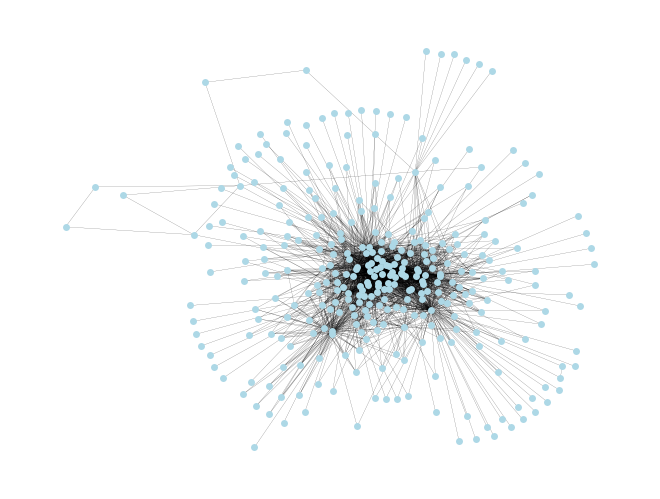

In [97]:
# 1. Set up the networkx object
# Set the edges to an array of origin and destination the officially delayed flights
edges = officialDelayM[['Origin', 'Dest']].values
print(len(edges)) #The total number of delayed flights for the month

# Create a networkx object, M for March
M = nx.from_edgelist(edges)

# Set the sizes of the nodes to correlate with the number of flights through the airport (connection)
# (from source 2)
deg = nx.degree(M)
sizes = [5 * deg[iata] for iata in M.nodes]

# Sets node labels for only the airports that are associate with at least 75 unique flight routes
# (from source 2)
labels = {iata: iata if deg[iata] >= 50 else ''
          for iata in M.nodes}
# Graphing options for the preliminary, unmapped graph
options = { 'node_color': 'lightblue',
            'node_size': 25,
            'linewidths': 0,
            'width': 0.1,
            'with_labels': False}
# Preliminary graph
nx.draw(M, **options)

The preliminary graph shows a large cluster of airports in the middle. Roughly 20 of them are in the denser areas. 20 airports therefore are expected to host the most amount of flights through them and will be reflected on the mapped graph as well.

3. Initialize the U.S. map: The pygris package is a great package that uses data from the U.S. Census Bureau to create the underlying map and to shift and resize it properly (source 3). 

In [ ]:
# This shifts the U.S. map so that Alaska, Hawaii and Puerto Rico are below or to the side of the continental U.S. 
us = states(cb=True, resolution="20m")
us_rescaled = shift_geometry(us)

Using the default year of 2024


4. Mapping the network to the U.S. map

In [93]:
# This code block establishes the geopandas coordinates for each of the airports 
# so they can be mapped in their proper locations.

# Removes unnessesary information from the airport dictionaries - just looking for the coordinates
remove_keys = {'icao', 'iata', 'name', 'city', 'subd', 'country', 'elevation', 'tz', 'lid'}

airports = { # AI also helped me write this part, the nested dictionaries was tough for me, but I understand them better now
    key: {k: v for k, v in data.items() if k not in remove_keys}
    for key, data in iata_airports.items()
}

# Creates a list from the new nested dictionary with just the airports AI helped write this section
airport_list = []
for iata_code, data in airports.items():
  if iata_code in USairports: #only need the U.S. airports
    airport_list.append({
        'iata': iata_code,
        'lat': data['lat'],
        'lon': data['lon']
    })

airports_df = pd.DataFrame(airport_list) # Geopandas needs a dataframe to create those geopandas point object

# Convert DataFrame to GeoDataFrame, AI was helpful writing this as well, the crs was a little confusing
airports_gdf = gpd.GeoDataFrame(
    airports_df,
    geometry=gpd.points_from_xy(airports_df.lon, airports_df.lat), #changes the latitude and longitude to geopandas point objects
    crs="EPSG:4326" # make sure we are mapping to the same coordinate system as the pygris map
)
# Reproject airports to match pygris states CRS - from AI
airports_gdf = airports_gdf.to_crs(us_rescaled.crs)

# Shift airport geometries using pygris so they are mapped properly to the shifted states
airports_shifted = shift_geometry(airports_gdf)

# Build node positions - AI helped with this, the nodes were still plotting incorrectly
node_positions = {
    row['iata']: (row.geometry.x, row.geometry.y)
    for idx, row in airports_shifted.iterrows()
}


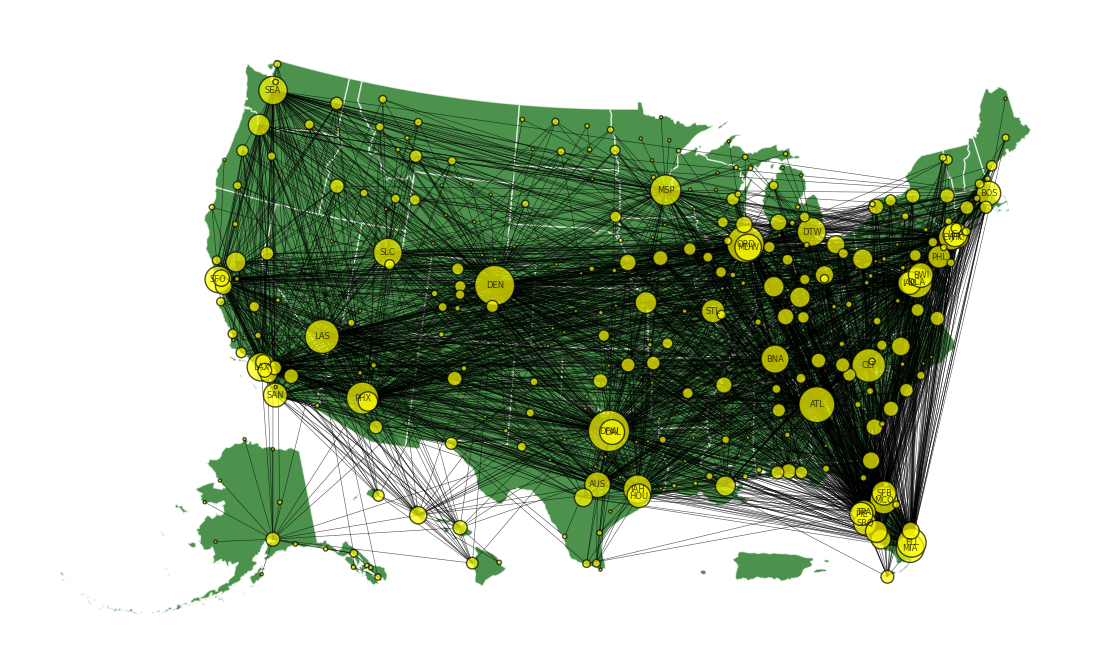

In [99]:
# Plotting the graphs
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes 

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

options = {'pos': node_positions, #Position of the nodes - makes sure they are mapped in their geographic spots
    'ax': ax, # Axes
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7, # Changes the opaqueness of the nodes
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(M, **options)


ax.set_axis_off() # Don't want the axes
plt.show()

Dener areas on the graph signify flight routes/areas that have more delays compared with less dense areas. Larger node sizes have more delayed flights passing through the airport when compared with smaller nodes. Labeles nodes are airports associated with at least 50 flight delays. Some major aiports associated with delays are DFW (Dallas), ATL (Atlanta), ORD (Chicago O'Hare), DEN (Denver),  and LAS (Las Vegas). Some main routes could be LAS to and from DEN, DEN to and from ORD or MDW, JFK to and from PIT, and MIA to and from BOS and ATL. 

In [245]:
# Centrality Measures
betweennessM = nx.betweenness_centrality(M)
degreeM = nx.degree_centrality(M)

#Top 5 airports for propogation of delays
sortMbetween = sorted(betweennessM.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortMbetween)

#Top 5 airports associated with the most delays
sortMdegree = sorted(degreeM.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortMdegree)


[('DFW', 0.21834269910172496), ('DEN', 0.1876897034103908), ('ORD', 0.11815845291258113), ('MSP', 0.07316032917540345), ('SEA', 0.05553756507285744)]
[('DFW', 0.5451713395638629), ('DEN', 0.514018691588785), ('ORD', 0.4423676012461059), ('ATL', 0.4143302180685358), ('LAS', 0.3707165109034268)]


First print statement is the top 5 airports with the most potenntial for delay propogagtion. These airports are Dallas Fort Worth, Denver, Chicago O'Hare, Minneapolis St. Paul and Seattle. The top 5 airports that host the most delayed flights are Dallas, Denver, Chicaco O'Hare, Atlanta and Las Vegas. 

# National Airspace Systems

In [225]:
# Set the edges to an array of origin and destination from only the National Airspace Systems delayed flights
edgesNM = nasM[['Origin', 'Dest']].values
print(len(edgesNM)) # Prints how many flights were delayed due to NAS

# Create the networkx object - NM for NAS, March
NM = nx.from_edgelist(edgesNM)

# Set the sizes of the nodes to correlate with the number of flights through the airport (connection)
# (from source 2)
deg = nx.degree(NM)
sizes = [5 * deg[iata] for iata in NM.nodes]

# Sets node labels for only the airports that are associate with at least 75 unique flight routes
# (from source 2)
labels = {iata: iata if deg[iata] >= 75 else ''
          for iata in NM.nodes}

59040


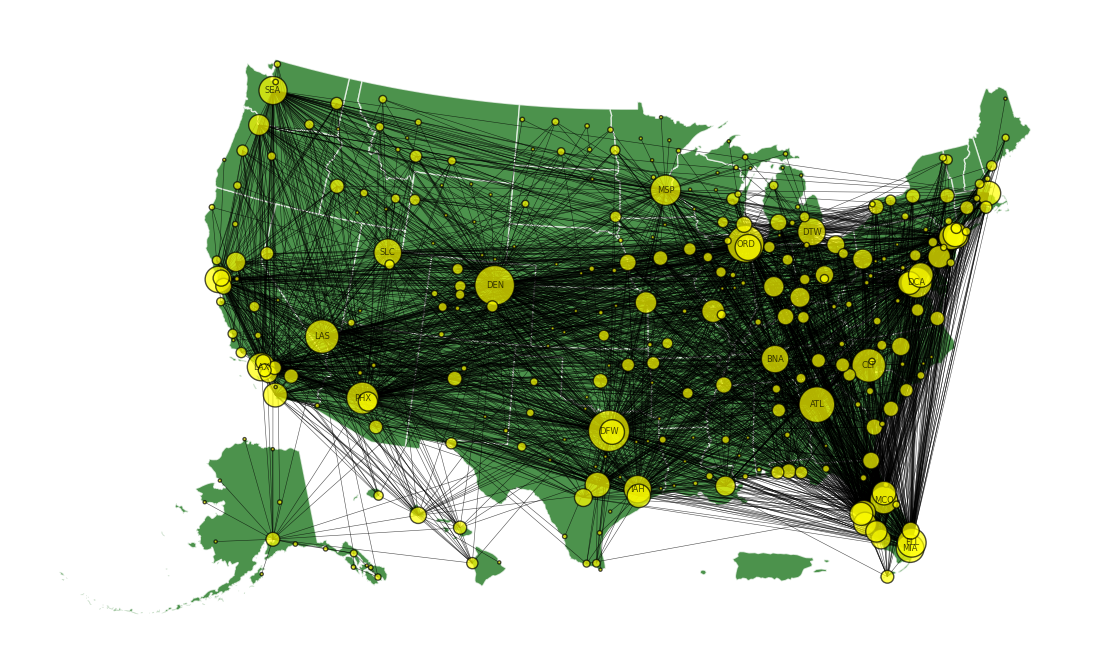

In [177]:
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # U.S. map 

# Graphing options
options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(NM, **options) # Draws the network


ax.set_axis_off() # Don't need axes
plt.show()

These graphs look similar, indicating that the major aiports and routes responsible for delays overall are still the major airports and routes for NAS delays. 

In [247]:
# Centrality Measures
betweennessMnas = nx.betweenness_centrality(NM)
degreeMnas = nx.degree_centrality(NM)

#Top 5 airports for propogation of delays
sortNMbetween = sorted(betweennessMnas.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortNMbetween)

#Top 5 airports associated with the most delays
sortNMdegree = sorted(degreeMnas.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortNMdegree)

# Percentace of NAS delayed flights
totalM = airDataM.shape[0]
nasMtotal = len(edgesNM)
ratioM = nasMtotal / totalM
print(ratioM)


[('DFW', 0.2270391171536899), ('DEN', 0.18952899226005993), ('ORD', 0.11811073255176101), ('MSP', 0.07505376049358709), ('SEA', 0.057805279832018)]
[('DFW', 0.546875), ('DEN', 0.509375), ('ORD', 0.44062500000000004), ('ATL', 0.41250000000000003), ('LAS', 0.36250000000000004)]
0.09825719953667336


First print statement is the top 5 airports with the most potenntial for delay propogagtion. These airports are Dallas Fort Worth, Denver, Chicago O'Hare, Minneapolis St. Paul and Seattle. The top 5 airports that host the most delayed flights are Dallas, Denver, Chicaco O'Hare, Atlanta and Las Vegas. Finally, about 10% of the total number of flights during March were delayed due to National Air Systems. 

# July

Steps outlined above have been repeated below for the July dataset. 

In [35]:
#Importing the June data
july = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_7/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_7.csv')
july.head() #examine the dataset

C:\Users\abiga\AppData\Local\Temp\ipykernel_4044\964616065.py:2: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  july = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_7/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_7.csv')


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2025        3      7          23          3  2025-07-23                AA   
1  2025        3      7          24          4  2025-07-24                AA   
2  2025        3      7          25          5  2025-07-25                AA   
3  2025        3      7          26          6  2025-07-26                AA   
4  2025        3      7          27          7  2025-07-27                AA   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19805                          AA      N450AN  ...   
1                     19805                          AA      N431AN  ...   
2                     19805                          AA      N444UW  ...   
3                     19805                          AA      N462AA  ...   
4                     19805                          AA      N458AL  ...   

   Div4TailNum  Div5Airport  Div5AirportID  Div5AirportSeqID Div5WheelsOn  \
0          NaN          NaN            NaN               NaN          NaN   
1          NaN          NaN            NaN               NaN          NaN   
2          NaN          NaN            NaN               NaN          NaN   
3          NaN          NaN            NaN               NaN          NaN   
4          NaN          NaN            NaN               NaN          NaN   

  Div5TotalGTime Div5LongestGTime  Div5WheelsOff Div5TailNum  Unnamed: 109  
0            NaN              NaN            NaN         NaN           NaN  
1            NaN              NaN            NaN         NaN           NaN  
2            NaN              NaN            NaN         NaN           NaN  
3            NaN              NaN            NaN         NaN           NaN  
4            NaN              NaN            NaN         NaN           NaN  

[5 rows x 110 columns]

In [87]:
# 2. Selecting just the columns of interest. 
# Columns that identify the airline, the flight, the date, the destination, the origin and the type of delay
# Originally I used a slice method to identify the names of the columns of interest
airDataJ = july[['FlightDate', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
              'Origin', 'OriginCityName', 'OriginCityMarketID', 'DepDelay',
              'Dest', 'DestCityName', 'DestCityMarketID', 'ArrDelay',
              'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].copy()
# Rename longer columns for easier calling
airDataJ.rename(columns = {'DOT_ID_Reporting_Airline':'DOT_ID', 'IATA_CODE_Reporting_Airline':'IATA_Code'}, inplace=True)

airDataJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631428 entries, 0 to 631427
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FlightDate          631428 non-null  object 
 1   DOT_ID              631428 non-null  int64  
 2   IATA_Code           631428 non-null  object 
 3   Tail_Number         629734 non-null  object 
 4   Origin              631428 non-null  object 
 5   OriginCityName      631428 non-null  object 
 6   OriginCityMarketID  631428 non-null  int64  
 7   DepDelay            616879 non-null  float64
 8   Dest                631428 non-null  object 
 9   DestCityName        631428 non-null  object 
 10  DestCityMarketID    631428 non-null  int64  
 11  ArrDelay            612811 non-null  float64
 12  CarrierDelay        177012 non-null  float64
 13  WeatherDelay        177012 non-null  float64
 14  NASDelay            177012 non-null  float64
 15  SecurityDelay       177012 non-nul

Now that I have a list of US airport codes and the columns that I am interested in, the data can be filtered for only delayed domestic flights.

In [89]:
# 3. Filter for Origin and Destination in the U.S.
usAirDataJ = airDataJ[
    airDataJ['Origin'].isin(USairports) &
    airDataJ['Dest'].isin(USairports)
]

# Filter for the delayed flights. Officially delayed flights are flights that have been delayed by over 15 min.
# Interested in only the flights that have arrived late, regardless of when they departed
officialDelayJ = usAirDataJ[usAirDataJ.ArrDelay>= 15]
officialDelayJ.head()

#Filter based on delay type
carrierJ = usAirDataJ[usAirDataJ.CarrierDelay > 0]
weatherJ = usAirDataJ[usAirDataJ.WeatherDelay > 0]
nasJ = usAirDataJ[usAirDataJ.NASDelay > 0]
securityJ = usAirDataJ[usAirDataJ.SecurityDelay > 0]
lateJ = usAirDataJ[usAirDataJ.LateAircraftDelay > 0]

In [163]:
portland = nasJ[(nasJ.Origin == 'PDX') | (nasJ.Dest == 'PDX')]
portland.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, 372 to 625841
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FlightDate          1213 non-null   object 
 1   DOT_ID              1213 non-null   int64  
 2   IATA_Code           1213 non-null   object 
 3   Tail_Number         1213 non-null   object 
 4   Origin              1213 non-null   object 
 5   OriginCityName      1213 non-null   object 
 6   OriginCityMarketID  1213 non-null   int64  
 7   DepDelay            1213 non-null   float64
 8   Dest                1213 non-null   object 
 9   DestCityName        1213 non-null   object 
 10  DestCityMarketID    1213 non-null   int64  
 11  ArrDelay            1213 non-null   float64
 12  CarrierDelay        1213 non-null   float64
 13  WeatherDelay        1213 non-null   float64
 14  NASDelay            1213 non-null   float64
 15  SecurityDelay       1213 non-null   float64
 16  LateAir

174749


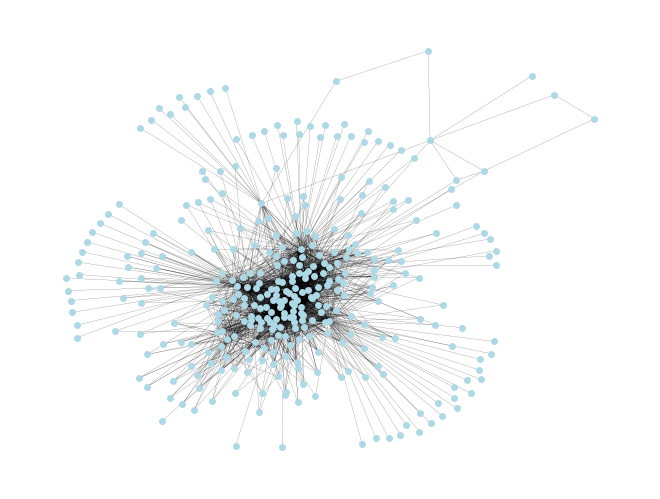

In [187]:
#Set the edges to an array of origin and destination from only the officially delayed flights
edgesJ = officialDelayJ[['Origin', 'Dest']].values
print(len(edgesJ)) # Prints the number of flights

#Create a networkx object - J for july
J = nx.from_edgelist(edgesJ)

# Set the sizes of the nodes to correlate with the number of flights through the airport (connection)
# (from source 2)
deg = nx.degree(J)
sizes = [5 * deg[iata] for iata in J.nodes]

# Sets node labels for only the airports that are associate with at least 75 unique flight routes
# (from source 2)
labels = {iata: iata if deg[iata] >= 75 else ''
          for iata in J.nodes}
#Graphing options
options = { 'node_color': 'lightblue',
            'node_size': 25,
            'linewidths': 0,
            'width': 0.1,
            'with_labels': False}
#Preliminary graph
nx.draw(J, **options)

Once again, the preliminary graph shows a large cluster of airports in the middle. Roughly 20 of them are in the denser areas. 20 airports therefore are expected to host the most amount of flights through them and will be reflected on the mapped graph as well.

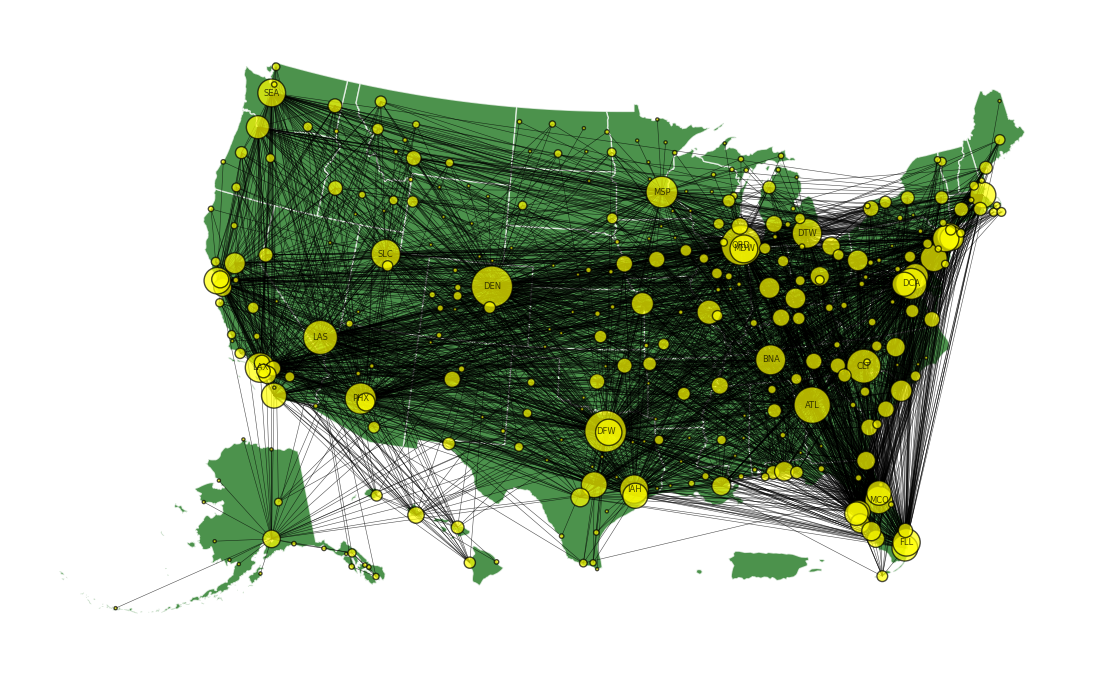

In [181]:
# The U.S. map and geopandas dataframe have already been initialized, no need to redo that

# Plot the network and U.S. graph
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(J, **options)


ax.set_axis_off()
plt.show()


July data is similar to March data, so the graph also looks similar. 

In [217]:
# Centrality Measures
betweennessJ = nx.betweenness_centrality(J)
degreeJ = nx.degree_centrality(J)

#Top 5 airports for propogation of delays
sortJbetween = sorted(betweennessJ.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortJbetween)

#Top 5 airports associated with the most delays
sortJdegree = sorted(degreeJ.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortJdegree)

[('DFW', 0.2044055178348601), ('DEN', 0.19972521523014986), ('ORD', 0.1583919730252876), ('ANC', 0.06705964318025832), ('ATL', 0.06377645523993218)]
[('DFW', 0.5327380952380952), ('DEN', 0.5208333333333333), ('ORD', 0.49107142857142855), ('ATL', 0.40773809523809523), ('LAS', 0.3571428571428571)]


For July, the top aiports for propogation potential are Dallas Fort Worth, Denver, Chicago O'Hare, Anchorage and Atlanta. Anchorage was unexpected as most flights do not have connections through Anchorage. Perhaps in July, more flights are going to and from Anchorage when compared with a winter month (like March). Compared to March, Anchorage and Atlanta are new top 5 propogators. The same airports are associated with the top 5 most flights.

# National Airspace Systems

In [183]:
#Set the edges to an array of origin and destination from only the Carrier delayed flights
edgesNJ = nasJ[['Origin', 'Dest']].values
print(len(edgesNJ))

#Create a networkx object - NJ for NAS, July
NJ = nx.from_edgelist(edgesNJ)

# Set the sizes of the nodes to correlate with the number of flights through the airport (connection)
# (from source 2)
deg = nx.degree(NJ)
sizes = [5 * deg[iata] for iata in NJ.nodes]

# Sets node labels for only the airports that are associate with at least 75 unique flight routes
# (from source 2)
labels = {iata: iata if deg[iata] >= 75 else ''
          for iata in NJ.nodes}

85948


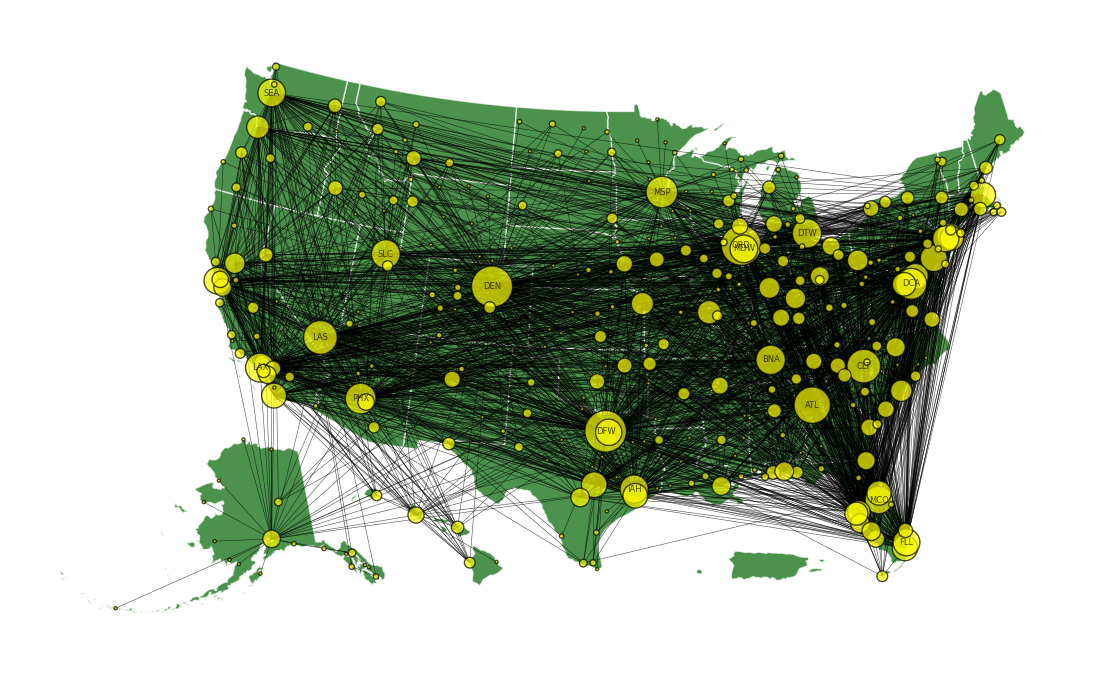

In [185]:
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

#Graph options
options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(NJ, **options) # Draws the network


ax.set_axis_off() # Don't need the axes
plt.show()

In [253]:
# Centrality Measures
betweennessJnas = nx.betweenness_centrality(NJ)
degreeJnas = nx.degree_centrality(NJ)

#Top 5 airports for propogation of delays
sortNJbetween = sorted(betweennessJnas.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortNJbetween)

#Top 5 airports associated with the most delays
sortNJdegree = sorted(degreeJnas.items(), key=lambda x:x[1], reverse=True)[:5]
print(sortNJdegree)

# Percentace of NAS delayed flights
totalJ = airDataJ.shape[0]
nasJtotal = len(edgesNJ)
ratioJ = nasJtotal / totalJ
print(ratioJ)


[('DFW', 0.20745844236708916), ('DEN', 0.2036498458145344), ('ORD', 0.16089163713617485), ('ANC', 0.06757682145220402), ('ATL', 0.06572874902835182)]
[('DFW', 0.5359281437125749), ('DEN', 0.5239520958083833), ('ORD', 0.4940119760479042), ('ATL', 0.4101796407185629), ('LAS', 0.3532934131736527)]
0.13611686526413147


The same airports appear in the centrality measures as appear in the main flight data. This makes sense as the NAS is just a section on the flights in general. The percentage of NAS delays compared with total flights is 13.6%, which is about 3.6% higher than those in March. 

In [257]:
#AI helped me to determine the correct coding for the spearman's correlation
df = pd.DataFrame({
    'NM': pd.Series(betweennessMnas),
    'NJ': pd.Series(betweennessJnas)
}).dropna()

rho, p = spearmanr(df['NM'], df['NJ'])
print("Spearman correlation:", rho, "p-value", p)

Spearman correlation: 0.9408789248013404 p-value 1.4978133488920898e-151


In [259]:
df = pd.DataFrame({
    'NM': pd.Series(degreeMnas),
    'NJ': pd.Series(degreeJnas)
}).dropna()

rho, p = spearmanr(df['NM'], df['NJ'])
print("Spearman correlation:", rho, "p-value", p)

Spearman correlation: 0.9761837975647382 p-value 4.169290995577139e-213


The Spearman correlations indicate that the NAS delays between the 2 months have simmilar structure. The same airports in both networks are experiencing the same risk for delay propogation and the same airports are assoiated with roughly the same amount of delays. The p-values for each of these calculations indicate that this is not by random chance and that these results are statistically significant. While it is unclear if the NAS delays are direcltly due to a decrease in staffing or lopsided staffing, is yet to be evaluated. Regardless, there is a 3.6% increase in NAS delays between March and July, so it is probable these shortagess and lopsidedness of air traffic control staffing could be causing these delays. Further studies correlating the staffing numbers and specific cause for the NAS delay could reaveal this causation. 

# Sources

1. https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr 
2. https://ipython-books.github.io/142-drawing-flight-routes-with-networkx/
3. https://walker-data.com/pygris/02-geometries/
4. https://freakonomics.com/podcast/is-the-air-traffic-control-system-broken/
5. https://www.usnews.com/news/us/articles/2025-10-31/air-traffic-controller-shortages-lead-to-broader-us-flight-delays-as-shutdown-nears-one-month-mark
6. https://www.faa.gov/air_traffic/nas
7. https://www.aspm.faa.gov/aspmhelp/index/Types_of_Delay.html